# Convert communities to jsonl so twarc can convert them back to a edgelist

In [4]:
import pandas as pd
import networkx as nx
import os, json
!pip install twarc
from twarc.expansions import ensure_flattened
import subprocess
done = True
if not done:
  jsonls = []
  for file in os.listdir('./'):
      if file.endswith('.csv'):
          df = pd.read_csv(file) 
          valid_ids = set(df["id"])

          with open("ukraine_stream_big.jsonl", "r") as infile: 
              with open(f"{file}.jsonl", "w") as outfile: 
                  jsonls.append(f"{file}.jsonl")
                  for line in infile: 
                      for tweet in ensure_flattened(json.loads(line)): 
                          if int(tweet["id"]) in valid_ids: 
                              outfile.write(json.dumps(tweet)+"\n")


  for file in jsonls:
      csv_users = file[:-6]+'_users_' + '.csv'
      subprocess.call(['twarc2', 'network', file, '--format', 'csv', csv_users, '--min-component-size', '5'])
      csv_tweets = file[:-6]+'_tweets_'+'.csv'
      subprocess.call(['twarc2', 'network', file, '--format', 'csv', csv_tweets, '--min-component-size', '5', '--nodes', 'tweets'])
      csv_tags = file[:-6]+'_tags_'+'.csv'
      subprocess.call(['twarc2', 'network', file, '--format', 'csv', csv_tags, '--min-component-size', '5', '--nodes', 'hashtags'])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 5.5 MB/s 
     |████████████████████████████████| 106 kB 29.5 MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=da2d647e154d180a98acad1d6304fceb94b9dce1f3e2fb68b91a62fc6dd2b155
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj
  Attempting uninstall: humanize
    Found existing installation: humanize 0.5.1
    Uninstalling humanize-0.5.1:
      Successfully uninstalled humanize-0.5.1


In [ ]:
for file in os.listdir('./'):
    if '_users_' in file:
        print(file)
        df = pd.read_csv(file, names=['source', 'target', 'weight', 'retweet', 'reply', 'quote', 'mention'])
        df['weight'] = df['weight'].map(lambda y: [int(x) for x in y.split() if x.isdigit()][0])
        df['retweet'] = df['retweet'].map(lambda y: [int(x) for x in y.split() if x.isdigit()][0])
        df['reply'] = df['reply'].map(lambda y: [int(x) for x in y.split() if x.isdigit()][0])
        df['quote'] = df['quote'].map(lambda y: [int(x) for x in y.split() if x.isdigit()][0])
        graph = nx.from_pandas_edgelist(df)
        df.to_csv(file)
        nx.write_gexf(graph, f"{file}_users_.gexf")
    if '_tweets_' in file:
        print(file)
        df = pd.read_csv(file)
        df['tweet'] = df['tweet'].map(lambda y: eval(y)['type'])
        print(df.head())
        graph = nx.from_pandas_edgelist(df)
        df.to_csv(file)
        nx.write_gexf(graph, f"{file}_tweets_.gexf")
    if '_tags_' in file:
        print(file)
        df = pd.read_csv(file)
        df['weight'] = df['weight'].map(lambda y: eval(y)['weight'])
        print(df.head())
        graph = nx.from_pandas_edgelist(df)
        df.to_csv(file)
        nx.write_gexf(graph, f"{file}.gexf")
        

community111.csv_tags_.csv
   Unnamed: 0                     source      target  weight
0           0                     #Putin   #Zelenski     288
1           1                     #Putin    #Ucrania      20
2           2                     #Putin   #Zelenzsy      20
3           3                     #Putin  #Occidente       1
4           4  #BedroomSessionsRadioShow      #Rusia       6
community111.csv_tweets_.csv
   Unnamed: 0        source        target    tweet
0           0  1.573014e+18  1.572984e+18    reply
1           1  1.573014e+18  1.572612e+18  retweet
2           2  1.573015e+18  1.572654e+18  retweet
3           3  1.573015e+18  1.573004e+18  retweet
4           4  1.573015e+18  1.572925e+18  retweet
community111.csv_users_.csv
community51.csv_tags_.csv
   Unnamed: 0    source              target  weight
0           0  #Ukraine             #Tigray    1409
1           1  #Ukraine           #Ethiopia      93
2           2  #Ukraine          #Palestine       2
3         

# information cascades


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
1      352065
2      128814
3       17486
4       11061
5        3205
        ...  
57          1
55          1
248         1
45          1
251         1
Name: weight, Length: 88, dtype: int64


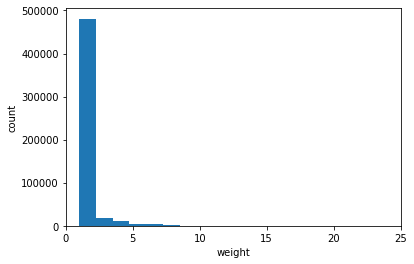

In [72]:
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
drive.mount('/content/drive/')

edgelist = pd.read_csv('/content/drive/MyDrive/stream_big_edgelist.csv', names = ['index', 'source', 'target', 'weight', 'retweet', 'reply', 'quote', 'mention'])
edgelist = edgelist.iloc[1:]

edgelist['weight'] = pd.to_numeric(edgelist['weight'])
edgelist = edgelist.sort_values(by='weight', ascending=False)
print(edgelist['weight'].value_counts())
plt.hist(edgelist['weight'], bins=200)
plt.xlim([0, 25])
plt.xlabel('weight')
plt.ylabel('count')
plt.show()



In [73]:
#!pip install ndlib
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

print(edgelist.head())
graph = nx.from_pandas_edgelist(edgelist, edge_attr='weight')
model = ep.IndependentCascadesModel(graph)
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)

for edge in graph.edges():
    config.add_edge_configuration("threshold", edge, 0.5)

model.set_initial_status(config)
iterations = model.iteration_bunch(25)
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot("diffusion0501.pdf")

           index           source           target  weight retweet reply  \
243741  243740.0   BogeyInTheDark   RussianEmbassy     251       0   124   
90593    90592.0     cathyjolly12   UN_News_Centre     248       0   124   
433456  433455.0      EDIT_BY_iAM  KremlinRussia_E     192       0     9   
84474    84473.0  JustinTrudeauDr       mfa_russia     169       6     4   
1107      1106.0     fckPutainMan     Alice_Weidel     160       0    68   

       quote           mention  
243741     0   'mention': 127}  
90593      0   'mention': 124}  
433456     0   'mention': 183}  
84474      0   'mention': 159}  
1107       0    'mention': 92}  


<Figure size 1440x720 with 0 Axes>

# use general threshold and use actual edge weights as transition probability


In [46]:
model = ep.GeneralThresholdModel(graph)

config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)

nodes = graph.nodes
edges = graph.edges(data=True)

for i in nodes:
    config.add_node_configuration("threshold", i, 0.01)
for e in edges:
    config.add_edge_configuration("weight", (e[0], e[1]), e[2]['weight']/251)

model.set_initial_status(config)
iterations = model.iteration_bunch(50)
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot("generalthreshold010o1.pdf")